# https://www.kaggle.com/c/mercari-price-suggestion-challenge 

The task is to make a model to suggest better item prices for sellers for the Mercari online store. The model should predict a price based on item category, brand, condition and text description.

In [1]:
import time
import re
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import pandas_profiling
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import accuracy_score, mean_squared_log_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb

import gc

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv('mercari/train.tsv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


Exploratory data analysis on a 1067 observations sample.

In [4]:
df_sample = pd.read_csv('mercari/train.tsv', nrows=1067, sep='\t')

In [37]:
df_sample.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


In [3]:
df_test = pd.read_csv('mercari/test_stg2.tsv', sep='\t')

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460725 entries, 0 to 3460724
Data columns (total 7 columns):
test_id              int64
name                 object
item_condition_id    int64
category_name        object
brand_name           object
shipping             int64
item_description     object
dtypes: int64(3), object(4)
memory usage: 184.8+ MB


In [40]:
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


There are six independent variables, all of them are categorical. Most are nominal, one binary ("shipping"), one ordinal ("item_condition_id). All have to be encoded for regression task. "brand_name" variable have many missing entries.

In [41]:
pandas_profiling.ProfileReport(df_sample)

Number of variables,8
Number of observations,1067
Total Missing (%),5.2%
Total size in memory,66.8 KiB
Average record size in memory,64.1 B
Numeric,3
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


Target variable "price" has a distribution with long right tail. To make its distribution closer to normal, the logarithm of it will be used. There can be seen a weak negative correlation between price and shipping (Spearman).

In [7]:
df_sample["price_log"] = np.log1p(df_sample["price"])
y_sample = df_sample["price_log"]

Mean log_price value by "shipping" feature. Price is usually higher when buyer pays for shipping.

In [8]:
df_sample.groupby("shipping").mean()["price_log"]

shipping
0   3.14
1   2.77
Name: price_log, dtype: float64

Mean log_price by condition. No clear dependencies can be seen.

In [11]:
df_sample.groupby("item_condition_id").mean()["price_log"]

item_condition_id
1   2.98
2   2.98
3   2.96
4   2.86
5   3.12
Name: price_log, dtype: float64

Boxplots of log_price distributions inside item condition groups. Variance decreases with a deterioration in quality. Further this feature will be evaluated by its contribution to the model error.

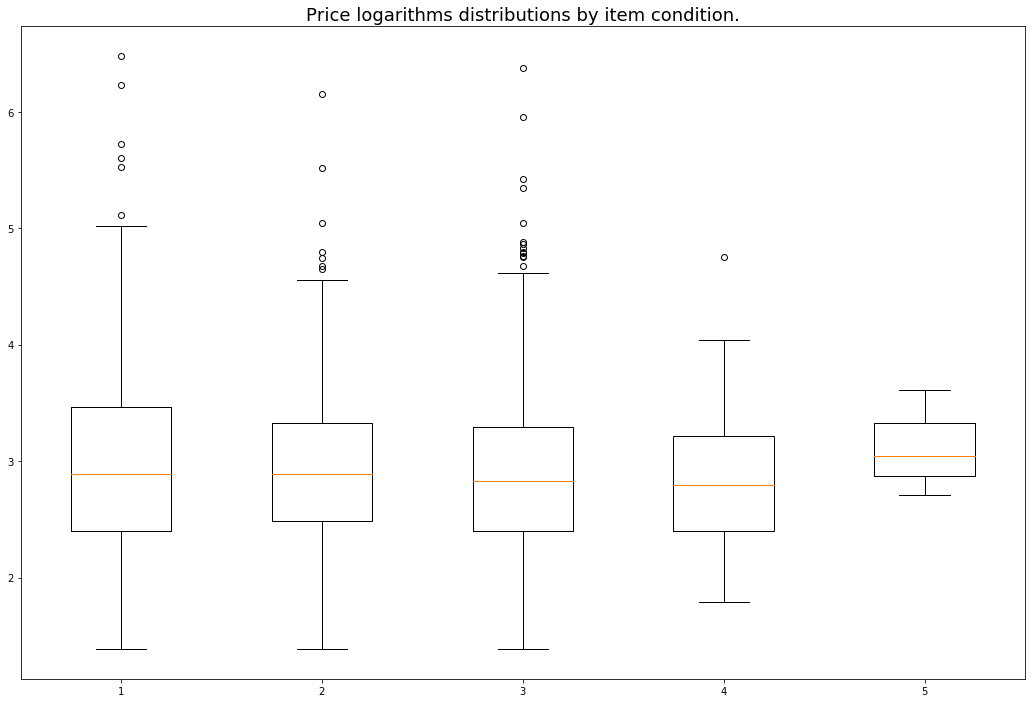

In [12]:
ai_df = df_sample[["item_condition_id", "price_log"]].copy()

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.boxplot([ai_df[ai_df["item_condition_id"]==i]["price_log"] for i in range(1,6)])
ax.set_title("Price logarithms distributions by item condition.", fontsize=18)

plt.show()

Mean log_price by brand name. There can be seen some dependencies. This information will be used for encoding "brand_name" variable. The new feature "brand_name_le" is created, which is correlated with log_price by 0.66.

In [4]:
def process_brand(data):
    data["brand_name"].fillna("NaN", inplace=True)
    bn_pl = data.groupby("brand_name").mean()["price_log"].sort_values()
    data['brand_name_le'] = data['brand_name'].map(bn_pl.to_dict())
    return

In [14]:
process_brand(df_sample)

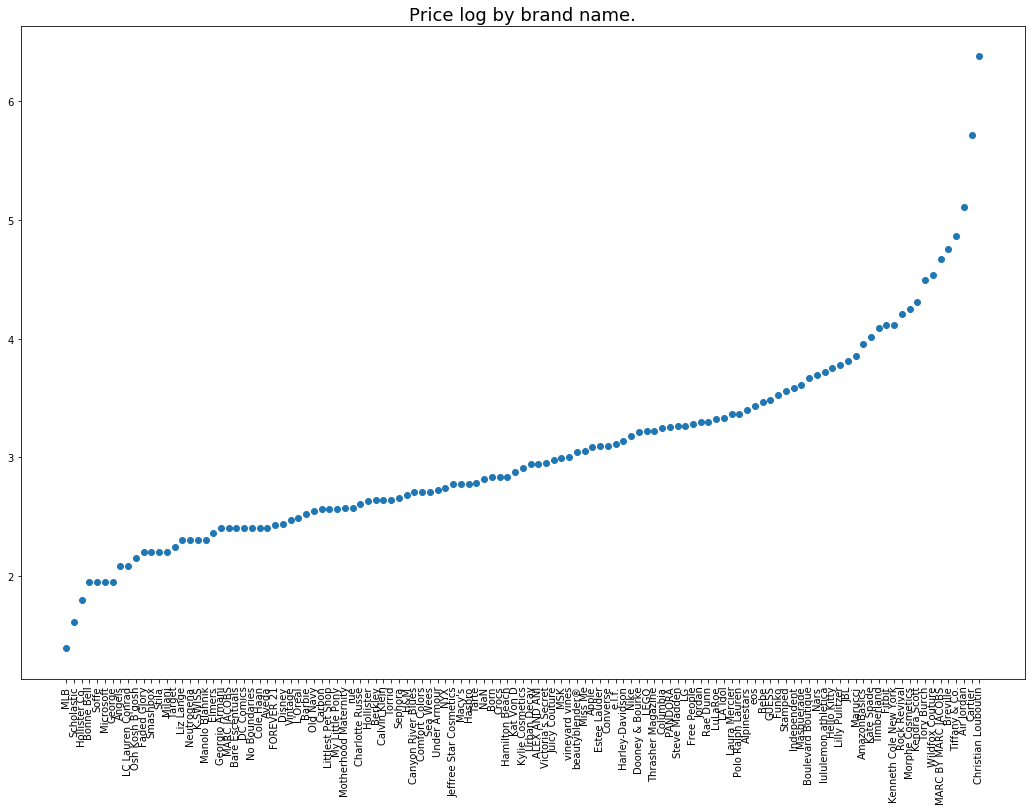

In [15]:
bn_pl = df_sample.groupby("brand_name").mean()["price_log"].sort_values()

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.scatter(bn_pl.index[1::2], bn_pl.values[1::2])
ax.set_title("Price log by brand name.", fontsize=18)
ax.set_xticklabels(bn_pl.index[1::2], rotation=90)

plt.show()

In [16]:
df_sample.corr()

,train_id,item_condition_id,price,shipping,price_log,brand_name_le
train_id,1.00,0.02,-0.04,0.03,-0.02,0.03
item_condition_id,0.02,1.00,-0.01,-0.18,-0.02,0.05
price,-0.04,-0.01,1.00,-0.09,0.74,0.58
shipping,0.03,-0.18,-0.09,1.00,-0.24,-0.18
price_log,-0.02,-0.02,0.74,-0.24,1.00,0.66
brand_name_le,0.03,0.05,0.58,-0.18,0.66,1.00


The ridge regression model will be used as a baseline. The input features will be "shipping", "brand_name_le", "item_condition_id". The condition feature was kept because it increased $R^2$ almost by 3%. The result of this model in kaggle was 0.64267.

In [5]:
df["price_log"] = np.log1p(df["price"])
process_brand(df)
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log,brand_name_le
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet,2.40,2.80
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,3.97,3.69
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,2.40,2.64
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...,3.58,2.80
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity,3.81,2.80


In [6]:
y = df["price_log"].values
X = df[["item_condition_id", "shipping", "brand_name_le"]].values
X_ic = df[["shipping", "brand_name_le"]].values

In [19]:
reg_ic = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_ic.fit(X_ic, y)
reg.fit(X, y)

print("R^2 with item_condition_id: {0}, \nR^2 without item_condition_id: {1}".format(reg.score(X, y),
                                                                                            reg_ic.score(X_ic, y)))
RMSLE_ic = np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg_ic.predict(X_ic))))
RMSLE = np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X))))
print("RMSLE with item_condition_id: {0}, \nRMSLE without item_condition_id: {1}".format(RMSLE, RMSLE_ic))

R^2 with item_condition_id: 0.27419972054841957, 
R^2 without item_condition_id: 0.2666387727738383
RMSLE with item_condition_id: 0.6062873409859204, 
RMSLE without item_condition_id: 0.6095400466339993


#### Feature making.    

Each item category was split into three subcategories (i.e. "Men/Tops/T-shirts" into "Men", "Tops", "T-shirts"). The subcategories were encoded by price log mean in each of them. The charts and correlation table below show the dependencies.

In [7]:
def process_category(data):
    data["category_name"].fillna("NaN/NaN/NaN", inplace=True)
    
    data["category_0"] = data["category_name"].str.extract("([^/]+)/[^/]+/[^/]+")
    data["category_1"] = data["category_name"].str.extract("[^/]+/([^/]+)/[^/]+")
    data["category_2"] = data["category_name"].str.extract("[^/]+/[^/]+/([^/]+)")
    
    cat0_pl = data.groupby("category_0").mean()["price_log"].sort_values()
    cat1_pl = data.groupby("category_1").mean()["price_log"].sort_values()
    cat2_pl = data.groupby("category_2").mean()["price_log"].sort_values()
    
    data['category_0_le'] = data['category_0'].map(cat0_pl.to_dict())
    data['category_1_le'] = data['category_1'].map(cat1_pl.to_dict())
    data['category_2_le'] = data['category_2'].map(cat2_pl.to_dict())

In [21]:
process_category(df_sample)
df_sample.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log,brand_name_le,category_0,category_1,category_2,category_0_le,category_1_le,category_2_le
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet,2.40,2.82,Men,Tops,T-shirts,3.17,2.75,2.64
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,3.97,3.97,Electronics,Computers & Tablets,Components & Parts,2.99,3.58,3.97
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,2.40,2.24,Women,Tops & Blouses,Blouse,3.10,2.67,2.68
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...,3.58,2.82,Home,Home Décor,Home Décor Accents,2.97,2.71,2.46
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity,3.81,2.82,Women,Jewelry,Necklaces,3.10,3.14,2.92


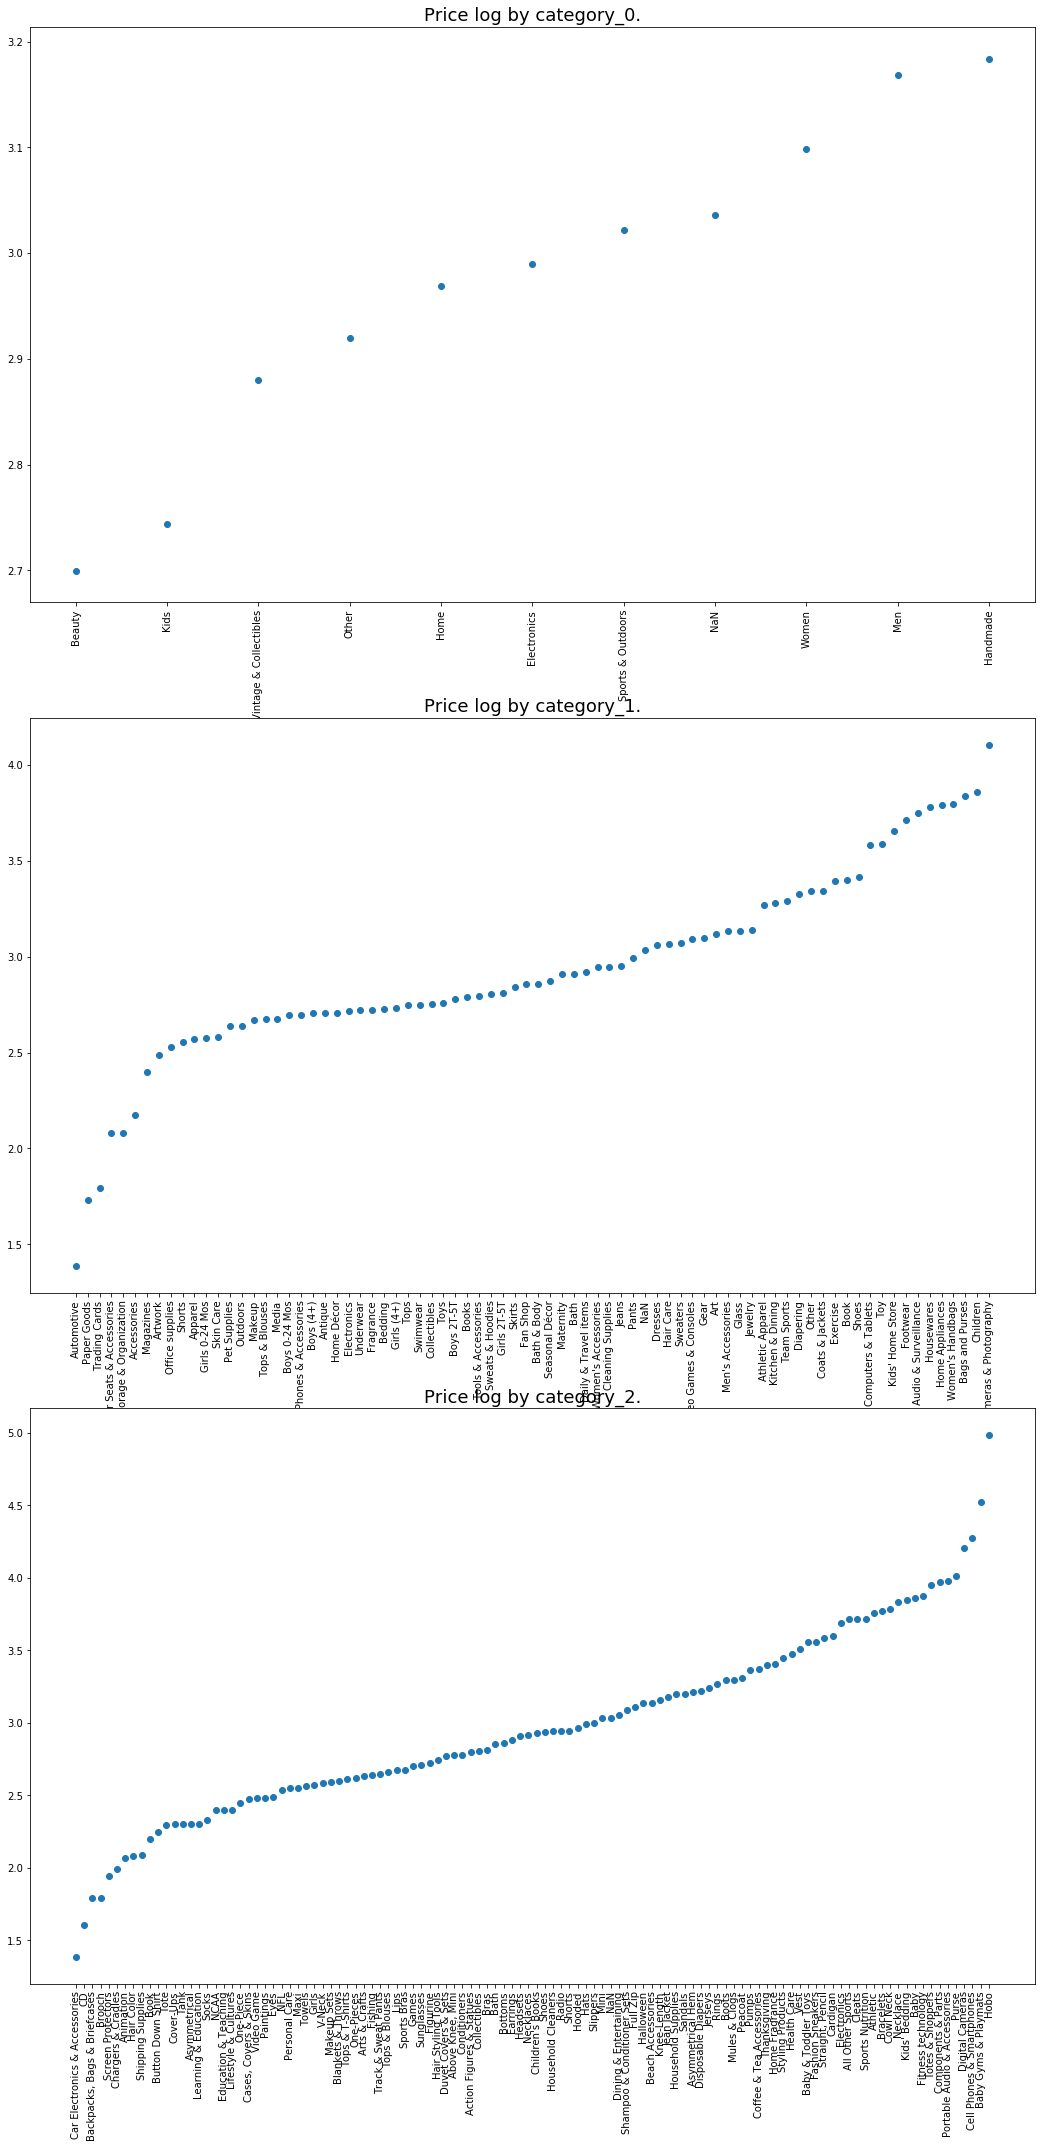

In [22]:
cat0_pl = df_sample.groupby("category_0").mean()["price_log"].sort_values()
cat1_pl = df_sample.groupby("category_1").mean()["price_log"].sort_values()
cat2_pl = df_sample.groupby("category_2").mean()["price_log"].sort_values()

fig, ax = plt.subplots(3, 1, figsize=(18, 36))

ax[0].scatter(cat0_pl.index, cat0_pl.values)
ax[0].set_title("Price log by category_0.", fontsize=18)
ax[0].set_xticklabels(cat0_pl.index, rotation=90)

ax[1].scatter(cat1_pl.index, cat1_pl.values)
ax[1].set_title("Price log by category_1.", fontsize=18)
ax[1].set_xticklabels(cat1_pl.index, rotation=90)

ax[2].scatter(cat2_pl.index[::2], cat2_pl.values[::2])
ax[2].set_title("Price log by category_2.", fontsize=18)
ax[2].set_xticklabels(cat2_pl.index[::2], rotation=90)

plt.show()

In [23]:
df_sample.corr()

,train_id,item_condition_id,price,shipping,price_log,brand_name_le,category_0_le,category_1_le,category_2_le
train_id,1.00,0.02,-0.04,0.03,-0.02,0.03,-0.01,0.05,0.02
item_condition_id,0.02,1.00,-0.01,-0.18,-0.02,0.05,0.20,0.11,0.09
price,-0.04,-0.01,1.00,-0.09,0.74,0.58,0.13,0.30,0.44
shipping,0.03,-0.18,-0.09,1.00,-0.24,-0.18,-0.17,-0.19,-0.20
price_log,-0.02,-0.02,0.74,-0.24,1.00,0.66,0.22,0.47,0.64
brand_name_le,0.03,0.05,0.58,-0.18,0.66,1.00,0.23,0.37,0.46
category_0_le,-0.01,0.20,0.13,-0.17,0.22,0.23,1.00,0.49,0.33
category_1_le,0.05,0.11,0.30,-0.19,0.47,0.37,0.49,1.00,0.70
category_2_le,0.02,0.09,0.44,-0.20,0.64,0.46,0.33,0.70,1.00


Checking the informativeness of the feature, made from length of the product description. The assumption that the seller, seeking to sell the product more expensive, will more carefully advertise it. Failed to see the dependence of the price with such a feature, it was excluded.

In [8]:
def process_description(data):
    data["item_description"].fillna("", inplace=True)
    data["description_length"] = data["item_description"].apply(lambda x: len(x) if x != "No description yet" else 0)

In [25]:
process_description(df_sample)
df_sample.corr()

,train_id,item_condition_id,price,shipping,price_log,brand_name_le,category_0_le,category_1_le,category_2_le,description_length
train_id,1.00,0.02,-0.04,0.03,-0.02,0.03,-0.01,0.05,0.02,0.01
item_condition_id,0.02,1.00,-0.01,-0.18,-0.02,0.05,0.20,0.11,0.09,-0.12
price,-0.04,-0.01,1.00,-0.09,0.74,0.58,0.13,0.30,0.44,0.06
shipping,0.03,-0.18,-0.09,1.00,-0.24,-0.18,-0.17,-0.19,-0.20,0.07
price_log,-0.02,-0.02,0.74,-0.24,1.00,0.66,0.22,0.47,0.64,0.04
brand_name_le,0.03,0.05,0.58,-0.18,0.66,1.00,0.23,0.37,0.46,0.01
category_0_le,-0.01,0.20,0.13,-0.17,0.22,0.23,1.00,0.49,0.33,-0.07
category_1_le,0.05,0.11,0.30,-0.19,0.47,0.37,0.49,1.00,0.70,0.00
category_2_le,0.02,0.09,0.44,-0.20,0.64,0.46,0.33,0.70,1.00,0.03
description_length,0.01,-0.12,0.06,0.07,0.04,0.01,-0.07,0.00,0.03,1.00


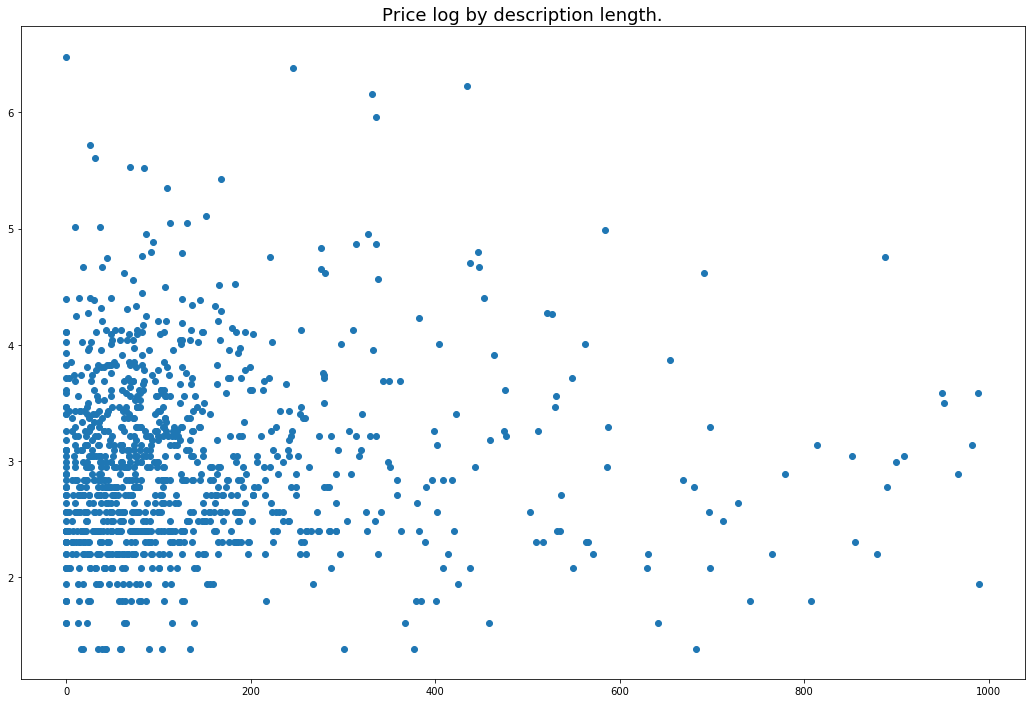

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.scatter(df_sample["description_length"], df_sample["price_log"])
ax.set_title("Price log by description length.", fontsize=18)

plt.show()

In [27]:
X_sample = df_sample[["item_condition_id", "shipping", "brand_name_le", "description_length"]].values
X_sample_dl = df_sample[["item_condition_id", "shipping", "brand_name_le"]].values

In [28]:
reg_dl = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_dl.fit(X_sample_dl, y_sample)
reg.fit(X_sample, y_sample)

print("R^2 with description_length: {0}, \nR^2 without description_length: {1}".format(reg.score(X_sample, y_sample),
                                                                                            reg_dl.score(X_sample_dl, y_sample)))
RMSLE_dl = np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg_dl.predict(X_sample_dl))))
RMSLE = np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg.predict(X_sample))))
print("RMSLE with description_length: {0}, \nRMSLE without description_length: {1}".format(RMSLE, RMSLE_dl))

R^2 with description_length: 0.461513973027001, 
R^2 without description_length: 0.4603948304494611
RMSLE with description_length: 0.5343379059485747, 
RMSLE without description_length: 0.5349655829330702


Applying cross-validation to ridge regression, and adding new features of encoded subcategories, increased $R^2$ and decreased model error. The error metric used was RMSLE, which is a requirement of this competition.

In [9]:
def get_non_text_features(data):
    return data[["item_condition_id", "shipping", "brand_name_le",
               "category_0_le", "category_1_le", "category_2_le"]].values

In [10]:
def apply_RidgeCV(X, y):
    reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
    reg.fit(X, y)
    print("R^2 = " + str(reg.score(X, y)))
    print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X))))))

In [11]:
def apply_Ridge(X, y, alpha=1.0):
    reg = Ridge(alpha=alpha)
    reg.fit(X, y)
    print("R^2 = " + str(reg.score(X, y)))
    print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X))))))

In [35]:
X_non_text_features = get_non_text_features(df_sample)
apply_RidgeCV(X_non_text_features, y_sample)

R^2 = 0.5946961529715824
RMSLE = 0.46393580126217254


Scaling of these features did not make a visible contribution to improving the result.

In [39]:
mmscaler = MinMaxScaler()
sdscaler = StandardScaler()

y_sample_scaled = mmscaler.fit_transform(y_sample.values.reshape(-1, 1))
X_sample_scaled = sdscaler.fit_transform(X_non_text_features)
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg.fit(X_sample_scaled, y_sample_scaled)
print("R^2 = " + str(reg.score(X_sample_scaled, y_sample_scaled)))
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(mmscaler.inverse_transform(y_sample_scaled)),
                                     y_pred=np.exp(mmscaler.inverse_transform(reg.predict(X_sample_scaled)))))))

R^2 = 0.5952487308773691
RMSLE = 0.46361992431660903


Creating new features by vectorizing the texts of the product name and description. When applied to the product description, CountVectorizer showed better results on the sample than TfidfVectorizer.

In [40]:
couvec = CountVectorizer()
X_name = couvec.fit_transform(df_sample["name"]).toarray()
X_non_text_name = np.c_[X_non_text_features, X_name]
apply_RidgeCV(X_non_text_name, y_sample)

R^2 = 0.7555540665706213
RMSLE = 0.36051319968302536


In [41]:
tfidf_descr = TfidfVectorizer(stop_words="english", max_features=5000)
X_descr = tfidf_descr.fit_transform(df_sample["item_description"]).toarray()
X = np.c_[X_non_text_features, X_name, X_descr]
number_non_text, number_name, number_descr = X_non_text_features.shape[1], X_name.shape[1], X_descr.shape[1]
apply_RidgeCV(X, y_sample)

R^2 = 0.7867814699172253
RMSLE = 0.33671658307364244


In [42]:
couvec_descr = CountVectorizer(stop_words="english")
X_descr = couvec_descr.fit_transform(df_sample["item_description"]).toarray()
X = np.c_[X_non_text_features, X_name, X_descr]
number_non_text, number_name, number_descr = X_non_text_features.shape[1], X_name.shape[1], X_descr.shape[1]
apply_RidgeCV(X, y_sample)

R^2 = 0.8810247688956493
RMSLE = 0.2516028461470034


Applying gradient boosting models and random forest.

In [53]:
reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X, y_sample)
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg_xgb.predict(X))))))

RMSLE = 0.35016890102848736


In [54]:
reg_lgb= lgb.LGBMRegressor()
reg_lgb.fit(X, y_sample.ravel())
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg_lgb.predict(X))))))

RMSLE = 0.26098753573515227


In [55]:
param_rf = {"max_depth": [3,6,9,12,None]}
reg_rf= RandomForestRegressor(n_estimators=100, random_state=42)
grd = GridSearchCV(reg_rf, param_grid=param_rf, cv=5, scoring="neg_mean_squared_error", n_jobs=7, verbose=2)
grd.fit(X, y_sample)
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(grd.predict(X))))))
print(grd.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:  1.7min finished
D:\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RMSLE = 0.27702203007867016
{'max_depth': 12}


Ensembling the two models with best results (Ridge and LGBM).

In [57]:
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg.fit(X, y_sample)
y_a = (reg.predict(X) + reg_lgb.predict(X)) / 2
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(y_a)))))

RMSLE = 0.24361749139782243


This ensemble will be used to make prediction for the whole dataset.

In [12]:
process_category(df)
df["item_description"].fillna("NaN", inplace=True)
df_test["item_description"].fillna("NaN", inplace=True)

y = df["price_log"].values
X_non_text_features = get_non_text_features(df)
non_text_features_number = X_non_text_features.shape[1]

In [13]:
name_full = pd.concat([df["name"], df_test["name"]], 0)
descr_full = pd.concat([df["item_description"], df_test["item_description"]], 0)
train_num = df.shape[0]

In [14]:
couvec_name = CountVectorizer(min_df=10)
name = couvec_name.fit_transform(name_full)

On a full training set, when vectorizing a product description, TfidfVectorizer achieved better result than the CountVectorizer.

In [15]:
tfidf_descr = TfidfVectorizer(stop_words="english", max_features=50000)
descr = tfidf_descr.fit_transform(descr_full)

In [16]:
X = scipy.sparse.hstack((X_non_text_features, name[:train_num], descr[:train_num])).tocsr()

In [24]:
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg.fit(X, y)
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X))))))
print("alpha = {}".format(reg.alpha_))

RMSLE = 0.44277547785997334
alpha = 10.0


LGBM parameters search.

The search was conducted on a learning_rate (0.5, 0.75, 1), num_boost_round (1000, 2000, 3000), max_depth (2, 3, 4) and num_leaves (50, 100, 150).

In [20]:
lgb_param_grid = {"learning_rate": [0.75],
                  "num_boost_round": [3000],
                 "max_depth": [4],
                 "num_leaves": [50]}

In [21]:
reg_lgb3 = lgb.LGBMRegressor(application="regression", metric="RMSE")
grd_search = GridSearchCV(reg_lgb3, param_grid=lgb_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=4, verbose=3)

In [24]:
grd_search.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed: 42.9min remaining: 21.5min
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 52.7min finished
D:\Programs\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMRegressor(application='regression', boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.1, max_depth=-1, metric='RMSE',
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'learning_rate': [0.75], 'num_boost_round': [3000], 'max_depth': [4], 'num_leaves': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [25]:
grd_search.best_params_

{'learning_rate': 0.75,
 'max_depth': 4,
 'num_boost_round': 3000,
 'num_leaves': 50}

Final LGBM training.

In [23]:
d_train = lgb.Dataset(X, label=y)
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 4,
        'num_leaves': 50,        
        'metric': 'RMSE',
    }

reg_lgb4 = lgb.train(params, train_set=d_train, num_boost_round=3000) 
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg_lgb4.predict(X))))))

RMSLE = 0.39523744668682786


LGBM with Ridge.

In [25]:
y_comb = (reg.predict(X) + reg_lgb4.predict(X))/2
print("RMSLE = " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(y_comb)))))

RMSLE = 0.4041001547884456


For the submission two last models were chosen. LGBM with the best parameters found resulted in kaggle score 0.45426, its ensembling with ridge regression - 0.45099.